In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.3866142530000047
GPU (s):
0.10773129900000811
GPU speedup over CPU: 31x


In [ ]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
from os import listdir
import cv2
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("The number of images with facemask labelled 'wit_mask':",len(os.listdir('/content/drive/My Drive/dataset/with_mask')))
print("The number of images with facemask labelled 'without_mask':",len(os.listdir('/content/drive/My Drive/dataset/without_mask')))

NameError: ignored

In [ ]:
def data_summary(main_path):
    
    yes_path = main_path+'with_mask'
    no_path = main_path+'without_mask'
        
    # number of files (images) that are in the the folder named 'with_mask'
    no_with_mask = len(listdir(yes_path))
    # number of files (images) that are in the the folder named 'without_mask'
    no_without_mask = len(listdir(no_path))
    # number of all examples
    total = (no_with_mask+no_without_mask)
    
    with_mask_perc = (no_with_mask* 100.0)/ total
    without_mask_perc = (no_without_mask* 100.0)/ total
    
    print(f"Number of examples: {total}")
    print(f"Percentage of positive examples: {with_mask_perc}%, number of positive (with_mask) examples: {no_with_mask}") 
    print(f"Percentage of negative examples: {without_mask_perc}%, number of neg (without_mask) examples: {no_without_mask}") 
    
main_path_of_the_images = '/content/drive/My Drive/dataset/'    
data_summary(main_path_of_the_images)

Number of examples: 3835
Percentage of positive examples: 49.960886571056065%, number of positive (with_mask) examples: 1916
Percentage of negative examples: 50.039113428943935%, number of neg (without_mask) examples: 1919


In [ ]:
def spliting_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    dataset = []
    
    for image_file in os.listdir(SOURCE):
        data = SOURCE + image_file
        if(os.path.getsize(data) > 0):
            dataset.append(image_file)
        else:
            print('Skipped ' + file)
            print('Invalid file i.e zero size')
    
    train_set_length = int(len(dataset) * SPLIT_SIZE)
    test_set_length = int(len(dataset) - train_set_length)
    train_set = dataset[0:train_set_length]
    test_set = dataset[-test_set_length:]
       
    for image_file in train_set:
        temp_train_set = SOURCE + image_file
        final_train_set = TRAINING + image_file
        copyfile(temp_train_set, final_train_set)
    
    for image_file in test_set:
        temp_test_set = SOURCE + image_file
        final_test_set = TESTING + image_file
        copyfile(temp_test_set, final_test_set)

       
        
with_mask_source_dir = "/content/drive/My Drive/dataset/with_mask/"
with_mask_training_dir = "/content/drive/My Drive/facemask_dataset/training/with_mask_train/"
with_mask_testing_dir = "/content/drive/My Drive/facemask_dataset/testing/with_mask_test/"
without_mask_source_dir = "/content/drive/My Drive/dataset/without_mask/"
without_mask_training_dir = "/content/drive/My Drive/facemask_dataset/training/without_mask_train/"
without_mask_testing_dir = "/content/drive/My Drive/facemask_dataset/testing/without_mask_test/"
split_size = .8
spliting_data(with_mask_source_dir, with_mask_training_dir, with_mask_testing_dir, split_size)
spliting_data(without_mask_source_dir, without_mask_training_dir, without_mask_testing_dir, split_size)

In [ ]:
print("The number of images with facemask in the training set labelled 'with mask':", len(os.listdir('/content/drive/My Drive/facemask_dataset/training/with_mask_train')))
print("The number of images with facemask in the test set labelled 'with mask':", len(os.listdir('/content/drive/My Drive/facemask_dataset/testing/with_mask_test')))
print("The number of images without facemask in the training set labelled 'without mask':", len(os.listdir('/content/drive/My Drive/facemask_dataset/training/without_mask_train')))
print("The number of images without facemask in the test set labelled 'without mask':", len(os.listdir('/content/drive/My Drive/facemask_dataset/testing/without_mask_test')))

The number of images with facemask in the training set labelled 'with mask': 1531
The number of images with facemask in the test set labelled 'with mask': 383
The number of images without facemask in the training set labelled 'without mask': 1534
The number of images without facemask in the test set labelled 'without mask': 384


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(100, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(100, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(100, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
TRAINING_DIR = "/content/drive/My Drive/facemask_dataset/training"
#augumenting the data for increasing the accuracy on training the model
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=10, 
                                                    target_size=(150, 150))
VALIDATION_DIR = "/content/drive/My Drive/facemask_dataset/testing"
validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                                         batch_size=10, 
                                                         target_size=(150, 150))
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

Found 3065 images belonging to 2 classes.
Found 767 images belonging to 2 classes.


In [ ]:
import os
from PIL import Image
folder_path = '/content/drive/My Drive/facemask_dataset/training'
extensions = []
for fldr in os.listdir(folder_path):
    sub_folder_path = os.path.join(folder_path, fldr)
    for filee in os.listdir(sub_folder_path):
        file_path = os.path.join(sub_folder_path, filee)
        print('** Path: {}  **'.format(file_path), end="\r", flush=True)
        im = Image.open(file_path)
        rgb_im = im.convert('RGB')
        if filee.split('.')[1] not in extensions:
            extensions.append(filee.split('.')[1])

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
import os
from PIL import Image
folder_path = '/content/drive/My Drive/facemask_dataset/testing'
extensions = []
for fldr in os.listdir(folder_path):
    sub_folder_path = os.path.join(folder_path, fldr)
    for filee in os.listdir(sub_folder_path):
        file_path = os.path.join(sub_folder_path, filee)
        print('** Path: {}  **'.format(file_path), end="\r", flush=True)
        im = Image.open(file_path)
        rgb_im = im.convert('RGB')
        if filee.split('.')[1] not in extensions:
            extensions.append(filee.split('.')[1])

In [ ]:
history = model.fit_generator(train_generator,
                              epochs=30,
                              validation_data=validation_generator,
                              callbacks=[checkpoint])

Epoch 1/30
 94/307 [========>.....................] - ETA: 23s - loss: 0.5279 - acc: 0.7436

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


307/307 [==============================] - 36s 116ms/step - loss: 0.4147 - acc: 0.8235 - val_loss: 0.2564 - val_acc: 0.8866
Epoch 2/30
307/307 [==============================] - 35s 115ms/step - loss: 0.3361 - acc: 0.8672 - val_loss: 0.2046 - val_acc: 0.9309
Epoch 3/30
307/307 [==============================] - 35s 114ms/step - loss: 0.3206 - acc: 0.8734 - val_loss: 0.2235 - val_acc: 0.9035
Epoch 4/30
307/307 [==============================] - 35s 113ms/step - loss: 0.3143 - acc: 0.8728 - val_loss: 0.3251 - val_acc: 0.9009
Epoch 5/30
307/307 [==============================] - 35s 113ms/step - loss: 0.3240 - acc: 0.8692 - val_loss: 0.2818 - val_acc: 0.9244
Epoch 6/30
307/307 [==============================] - 35s 116ms/step - loss: 0.3115 - acc: 0.8754 - val_loss: 0.1950 - val_acc: 0.9387
Epoch 7/30
307/307 [==============================] - 35s 115ms/step - loss: 0.2935 - acc: 0.8920 - val_loss: 0.1864 - val_acc: 0.9452
Epoch 8/30
307/307 [==============================] - 35s 113ms/st

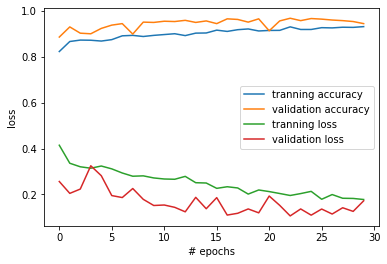

In [ ]:
from matplotlib import pyplot as plt 

plt.plot(history.history['acc'] , label='tranning accuracy')
plt.plot(history.history['val_acc'] , label = 'validation accuracy')
plt.plot(history.history['loss'] , label='tranning loss')
plt.plot(history.history['val_loss'] , label = 'validation loss')
plt.xlabel("# epochs")
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
face_clsfr=cv2.CascadeClassifier('/content/drive/My Drive/haarcascade_frontalface_default.xml')
labels_dict={0:'without_mask',1:'with_mask'}
color_dict={0:(0,0,255),1:(0,255,0)}

size = 4
webcam = cv2.VideoCapture(0) #Use camera 0


In [ ]:
#
# based on: https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=2viqYx97hPMi
#

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import numpy as np

def init_camera():
  """Create objects and functions in HTML/JavaScript to access local web camera"""

  js = Javascript('''

    // global variables to use in both functions
    var div = null;
    var video = null;   // <video> to display stream from local webcam
    var stream = null;  // stream from local webcam
    var canvas = null;  // <canvas> for single frame from <video> and convert frame to JPG
    var img = null;     // <img> to display JPG after processing with `cv2`

    async function initCamera() {
      // place for video (and eventually buttons)
      div = document.createElement('div');
      document.body.appendChild(div);

      // <video> to display video
      video = document.createElement('video');
      video.style.display = 'block';
      div.appendChild(video);

      // get webcam stream and assing to <video>
      stream = await navigator.mediaDevices.getUserMedia({video: true});
      video.srcObject = stream;

      // start playing stream from webcam in <video>
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // <canvas> for frame from <video>
      canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      //div.appendChild(input_canvas); // there is no need to display to get image (but you can display it for test)

      // <img> for image after processing with `cv2`
      img = document.createElement('img');
      img.width = video.videoWidth;
      img.height = video.videoHeight;
      div.appendChild(img);
    }

    async function takeImage(quality) {
      // draw frame from <video> on <canvas>
      canvas.getContext('2d').drawImage(video, 0, 0);

      // stop webcam stream
      //stream.getVideoTracks()[0].stop();

      // get data from <canvas> as JPG image decoded base64 and with header "data:image/jpg;base64,"
      return canvas.toDataURL('image/jpeg', quality);
      //return canvas.toDataURL('image/png', quality);
    }

    async function showImage(image) {
      // it needs string "data:image/jpg;base64,JPG-DATA-ENCODED-BASE64"
      // it will replace previous image in `<img src="">`
      img.src = image;
      // TODO: create <img> if doesn't exists, 
      // TODO: use `id` to use different `<img>` for different image - like `name` in `cv2.imshow(name, image)`
    }

  ''')

  display(js)
  eval_js('initCamera()')

def take_frame(quality=0.8):
  """Get frame from web camera"""

  data = eval_js('takeImage({})'.format(quality))  # run JavaScript code to get image (JPG as string base64) from <canvas>

  header, data = data.split(',')  # split header ("data:image/jpg;base64,") and base64 data (JPG)
  data = b64decode(data)  # decode base64
  data = np.frombuffer(data, dtype=np.uint8)  # create numpy array with JPG data

  img = cv2.imdecode(data, cv2.IMREAD_UNCHANGED)  # uncompress JPG data to array of pixels

  return img

def show_frame(img, quality=0.8):
  """Put frame as <img src="data:image/jpg;base64,...."> """

  ret, data = cv2.imencode('.jpg', img)  # compress array of pixels to JPG data

  data = b64encode(data)  # encode base64
  data = data.decode()  # convert bytes to string
  data = 'data:image/jpg;base64,' + data  # join header ("data:image/jpg;base64,") and base64 data (JPG)

  eval_js('showImage("{}")'.format(data))  # run JavaScript code to put image (JPG as string base64) in <img>
                                           # argument in `showImage` needs `" "` 

In [ ]:
init_camera() #init javascript code
classifier = cv2.CascadeClassifier('/content/drive/My Drive/haarcascade_frontalface_default.xml')

while(True):

  im = take_frame()
  mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))
  #gray = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)

  faces = classifier.detectMultiScale(mini) ########
  for f in faces:
    (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
    face_img = im[y:y+w , x:x+w]###############
    resized = cv2.resize(face_img , (150,150)) # resize the face_img
    normalized = resized /255.0 # normalized the value to 0 and 1
    reshaped = np.reshape(normalized ,(1,150,150,3)) # convert the normalized img array to 4d for cnn
    reshaped = np.vstack([reshaped])
    result = model.predict(reshaped) #for getting the prediction

    # print(result)
    label = np.argmax(result , axis =1)[0] #########
    # print (label)

    cv2.rectangle(im , (x,y) , (x+w , y+h) ,color_dict[label] ,2) 
    #rectangle x,y one point and x+w ,y+h is another point. 2 is the border thin
    cv2.rectangle(im ,(x,y-40),(x+w , y) , color_dict[label] , -1) #-1 for color filled
    conf_perc = "{:.2f}%".format(result[0][label] * 100)
    cv2.putText(im , labels_dict[label]+" " +str(conf_perc) , (x,y-10) , cv2.FONT_HERSHEY_COMPLEX , 0.8,(255,255,255) , 2)
   
    #cv2_imshow(gray)  # it creates new image for every frame (it doesn't replace previous image) so it is useless
    #show_frame(gray)  # it replace previous image

    show_frame(im) #it replaces the previous images
    key = cv2.waitKey(1)

    if(key==27):
      break

cv2.destroyAllWindows()
source.release()

In [ ]:
from google.colab.patches import cv2_imshow
classifier = cv2.CascadeClassifier('/content/drive/My Drive/haarcascade_frontalface_default.xml')

im = cv2.imread(cv2.samples.findFile("/content/drive/My Drive/pic2.jpg"))
print(im.shape[0]/size)
mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))
#gray = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)

faces = classifier.detectMultiScale(mini) ########
for f in faces:
  (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
  face_img = im[y:y+w , x:x+w] ###############
  resized = cv2.resize(face_img , (150,150)) # resize the face_img
  normalized = resized /255.0 # normalized the value to 0 and 1
  reshaped = np.reshape(normalized ,(1,150,150,3)) # convert the normalized img array to 4d for cnn
  reshaped = np.vstack([reshaped])
  result = model.predict(reshaped) #for getting the prediction

  print(result)
  label = np.argmax(result , axis =1)[0] #########
  print (label)
  cv2.rectangle(im , (x,y) , (x+w , y+h) ,color_dict[label] ,2) 
  #rectangle x,y one point and x+w ,y+h is another point. 2 is the border thin
  cv2.rectangle(im ,(x,y-40),(x+w , y) , color_dict[label] , -1) #-1 for color filled
  conf_perc = "{:.2f}%".format(result[0][label] * 100)
  cv2.putText(im , labels_dict[label]+" " +str(conf_perc) , (x,y-10) , cv2.FONT_HERSHEY_COMPLEX , 0.8,(255,255,255) , 2)
  
  #cv2_imshow(gray)  # it creates new image for every frame (it doesn't replace previous image) so it is useless
  #show_frame(gray)  # it replace previous image

  # show_frame(im) #it replaces the previous images
  cv2_imshow(im)
  cv2.waitKey(0)


error: ignored